In [4]:
#deep fake detection
# import tensorflow as tf
# import keras 
# from keras.layers import Activation, Dense
# from keras.layers import Conv1D,Conv2D
# from keras.models import Sequential
# from keras import backend as k



In [5]:
#gpu accelaration on online editors
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [6]:
#CODING THE GENERATIVE ADVERSARIAL  NETWORK
#oading the functions
#dense--> noise layer of the network
#conv2dtranspose--> it enalbes us to convolve and upsacale the image at the same time
#it is equivalent to upsampling2d followed by conv2d
#LeakyReLU-->avoids gardeint vainsh problem
#BatchNormalisation--> helps to normalise the covultion result
#reshape--> helps to convert 1D array to 3D



In [7]:
#NOTES ON GANS
#, Minimax is a competition among Discriminator “D” and Generator “G”. “D” tries increment the
# possibility that accurately distinguishes true(real) and phoney (log D(x)), while “G” tries to decrease the possibility
# that D will forecast that its outputs seem to be counterfeit “log(1-D(G(z))”. In the aforementioned research paper, the
# GAN error rate estimated by calculation of loss can be noticed in equation 1 [4].
# 𝐺minD𝑚ax 𝑉(𝐷, 𝐺) = 𝐸x ~𝑝𝑑ata(𝑥)[𝑙ogD(𝑥)] + 𝐸𝐸𝐸𝐸~𝑝𝑝𝑧𝑧(𝑧𝑧)[𝑙𝑙𝑙𝑙𝑙𝑙(1 − 𝐷𝐷(𝐺𝐺(𝑧𝑧)))] (1)
# Where; G stands for Generator, D stands for Discriminator, Pdata(x) = real-world data distribution, P(z) = generator
# distribution, x = Pdata sample (x),z = a sample taken from P (z), D(x) denotes a discriminator network, G(z) denotes
# the generator network.

In [8]:
import glob
import time
import os 
import PIL
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import imageio
from IPython import display
import tensorflow as tf
import pandas as pd



In [9]:
pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [10]:
#LAOD AND PREPARE THE DATA
(train_images,train_labels),(_,_) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
#train_images.shape[0],28,28,1 means 0--> upsampling 28x28--> size, 1 means --> greyscale for color value is 3(rgb)
train_images = (train_images-127.5)/127.5 #normalize between [-1,1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
#batch and shuffle the data
train_dataset  = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BATCH_SIZE).batch(BATCH_SIZE)


In [11]:
data = tf.keras.datasets.mnist.load_data()
print(data)

((array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ...

In [12]:
#the generator

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))#7 rows , 7 coloumns and 256 channels)
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # Conv2DTranspose(128,(5,5)) means output size is 128 and kernel size is (5,5)
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


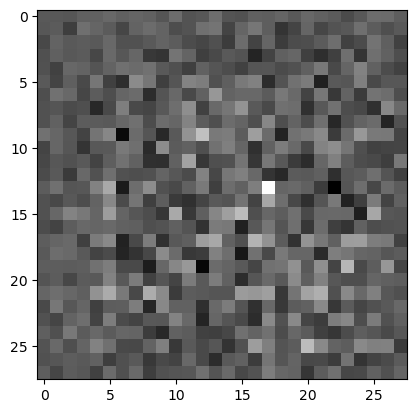

In [13]:
#plotting the summary and priniting the untrained image model
generator = make_generator_model()
noise = tf.random.normal([1,100])
generated_image = generator(noise,training = False)
plt.imshow(generated_image[0,:,:,0],cmap = 'gray')


In [14]:
# THE DISCRIMINATOR
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [15]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)



tf.Tensor([[-0.00113597]], shape=(1, 1), dtype=float32)


In [16]:
#define loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [17]:
#discriminator loss
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.zeros_like(fake_output),fake_output)

    

In [19]:
#defineing the optimizers
#we have to define to seperate optimizers because we are using adversarial networks
generator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)
#adam works slow on mac hence used legacy.adam



In [20]:
#SAVING CHECKPOINTS
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)


In [21]:
#defining the training loop
EPOCHS = 50
noise_dim = 100
num_example = 16
seed = tf.random.normal([num_example,noise_dim])


In [22]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
#The @tf.function decorator will automatically compile the function to TensorFlow code and then execute it on the GPU. This can significantly improve the performance of the function, especially if it is a computationally intensive function.
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [23]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [24]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

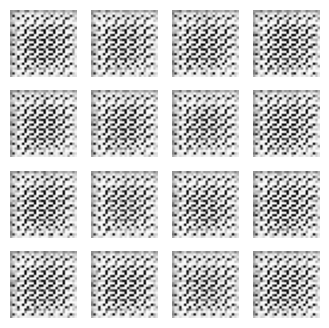

In [25]:
train(train_dataset, EPOCHS)

In [26]:
import tensorflow as tf
print(tf.__version__)


2.12.0


In [27]:
print(len(tf.config.list_physical_devices('GPU')))

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
0


In [28]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [29]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

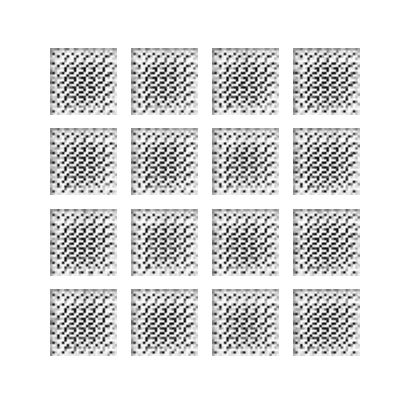

In [30]:
display_image(EPOCHS)

In [31]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

ValueError: Could not find a backend to open `dcgan.gif`` with iomode `wI`.
Based on the extension, the following plugins might add capable backends:
  pillow:  pip install imageio[pillow]
  GIF-PIL:  pip install imageio[pillow]
  pyav:  pip install imageio[pyav]


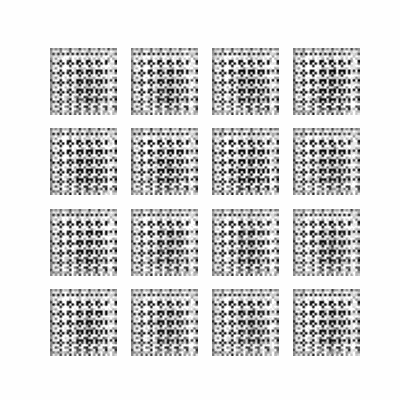

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
pip install tensorflow_docs

  Obtaining dependency information for tensorflow_docs from https://files.pythonhosted.org/packages/54/bc/baf662694e1deeac50432dfe48254d550c9e9d6021ab2fec7de98381da80/tensorflow_docs-2023.5.24.56664-py3-none-any.whl.metadata
  Using cached tensorflow_docs-2023.5.24.56664-py3-none-any.whl.metadata (929 bytes)
  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)
Using cached tensorflow_docs-2023.5.24.56664-py3-none-any.whl (183 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
import tensorflow as tf

# Explicitly set GPU device
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
        )
    except RuntimeError as e:
        print(e)


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0
